Setup:
This notebook was created and tested on an ml.m5.xlarge notebook instance.

In [19]:
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role
from sagemaker import Session

bucket = Session().default_bucket()
role = get_execution_role()
prefix = 'sagemaker/student-perf'

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer

Data:
We will be using a open dataset from: https://archive.ics.uci.edu/ml/datasets/student+performance

Data Set Information:

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). In [Cortez and Silva, 2008], the two datasets were modeled under binary/five-level classification and regression tasks. Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).

In [21]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip
!unzip -o student.zip

--2019-07-22 21:59:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20478 (20K) [application/x-httpd-php]
Saving to: ‘student.zip.6’

student.zip.6       100%[===================>]  20.00K  --.-KB/s    in 0.07s   

2019-07-22 21:59:19 (285 KB/s) - ‘student.zip.6’ saved [20478/20478]

Archive:  student.zip
  inflating: student-mat.csv         
  inflating: student-por.csv         
  inflating: student-merge.R         
  inflating: student.txt             


In [24]:
df = pd.read_csv('./student-mat.csv', sep=";")
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


Attribute Information:

Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets: 
1 school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira) 
2 sex - student's sex (binary: 'F' - female or 'M' - male) 
3 age - student's age (numeric: from 15 to 22) 
4 address - student's home address type (binary: 'U' - urban or 'R' - rural) 
5 famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3) 
6 Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart) 
7 Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education) 
8 Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education) 
9 Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other') 
10 Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other') 
11 reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other') 
12 guardian - student's guardian (nominal: 'mother', 'father' or 'other') 
13 traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour) 
14 studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours) 
15 failures - number of past class failures (numeric: n if 1<=n<3, else 4) 
16 schoolsup - extra educational support (binary: yes or no) 
17 famsup - family educational support (binary: yes or no) 
18 paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no) 
19 activities - extra-curricular activities (binary: yes or no) 
20 nursery - attended nursery school (binary: yes or no) 
21 higher - wants to take higher education (binary: yes or no) 
22 internet - Internet access at home (binary: yes or no) 
23 romantic - with a romantic relationship (binary: yes or no) 
24 famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent) 
25 freetime - free time after school (numeric: from 1 - very low to 5 - very high) 
26 goout - going out with friends (numeric: from 1 - very low to 5 - very high) 
27 Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high) 
28 Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high) 
29 health - current health status (numeric: from 1 - very bad to 5 - very good) 
30 absences - number of school absences (numeric: from 0 to 93) 

these grades are related with the course subject, Math or Portuguese: 
31 G1 - first period grade (numeric: from 0 to 20) 
31 G2 - second period grade (numeric: from 0 to 20) 
32 G3 - final grade (numeric: from 0 to 20, output target)

In [31]:
# convert categorical variables into numerical
def catToNum(df, excludeList):
    for col in df.select_dtypes(exclude=[np.number]):
        if col in excludeList: continue
        uniqueVal = df[col].unique()
        for i in range(len(uniqueVal)):
            df.loc[df[col]==uniqueVal[i], col]=i
catToNum(df, [])

In [32]:
# Move target column to first column as SageMaker algorithms require that format
df = pd.concat([df['G3'], df.drop(['G3'], axis=1)], axis=1)

In [33]:
df.head()

,G3,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,6,0,0,18,0,0,0,4,4,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,4,3,4,1,1,3,6,5,6
1,6,0,0,17,0,0,1,1,1,0,1,0,1,1,2,0,1,1,0,0,1,0,1,0,5,3,3,1,1,3,4,5,5
2,10,0,0,15,0,1,1,1,1,0,1,1,0,1,2,3,0,0,1,0,0,0,1,0,4,3,2,2,3,3,10,7,8
3,15,0,0,15,0,0,1,4,2,1,2,2,0,1,3,0,1,1,1,1,0,0,1,1,3,2,2,1,1,5,2,15,14
4,10,0,0,16,0,0,1,3,3,2,1,2,1,1,2,0,1,1,1,0,0,0,0,0,4,3,2,1,2,5,4,6,10


G3:


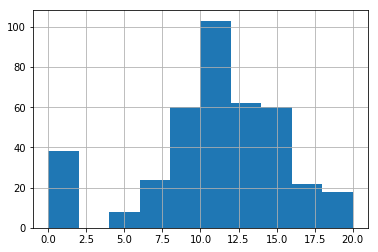

school:


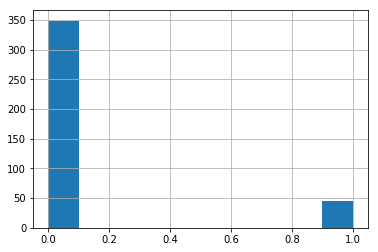

sex:


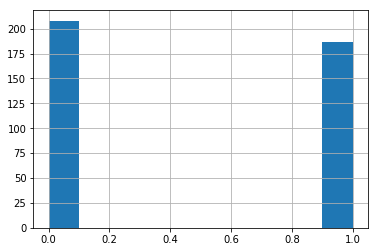

age:


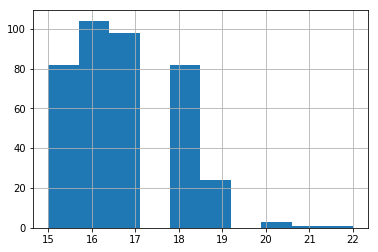

address:


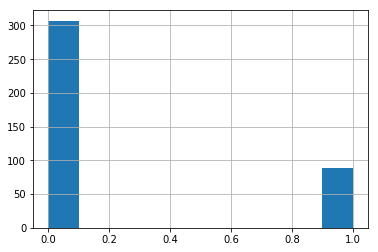

famsize:


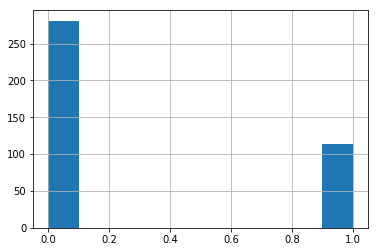

Pstatus:


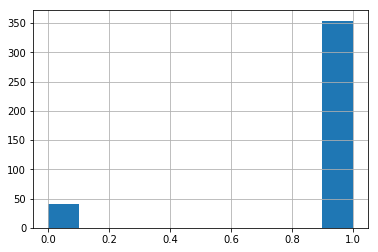

Medu:


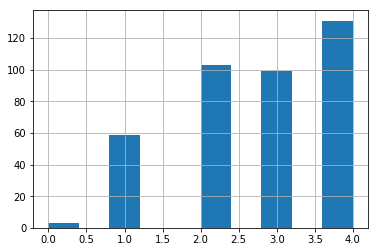

Fedu:


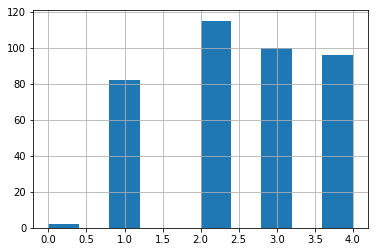

Mjob:


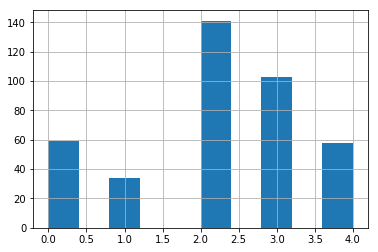

Fjob:


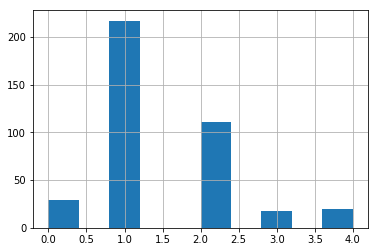

reason:


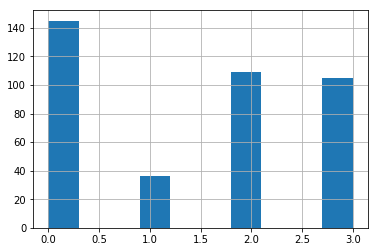

guardian:


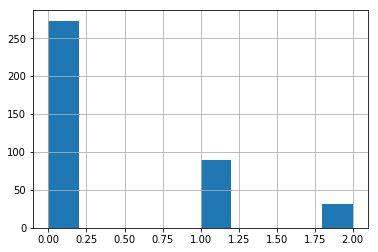

traveltime:


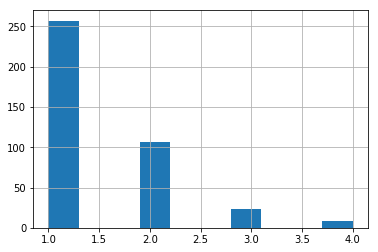

studytime:


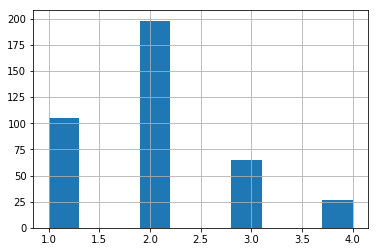

failures:


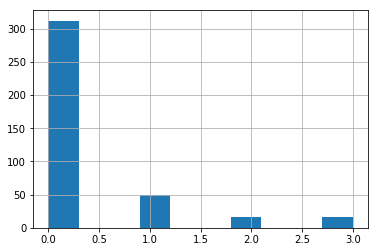

schoolsup:


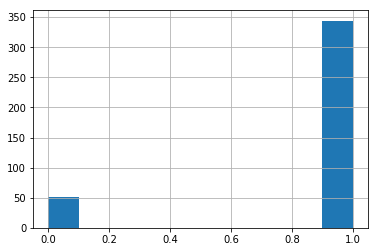

famsup:


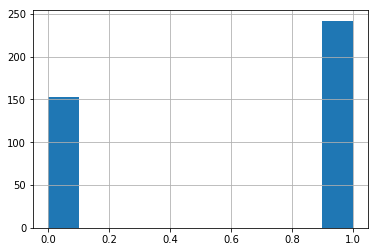

paid:


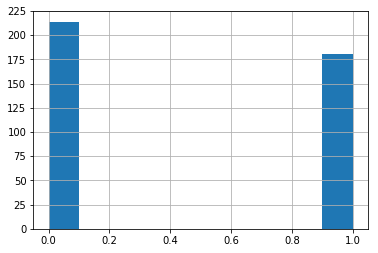

activities:


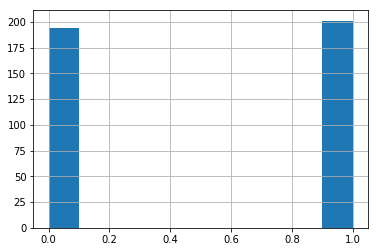

nursery:


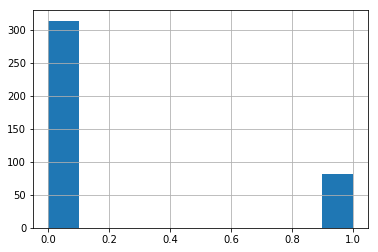

higher:


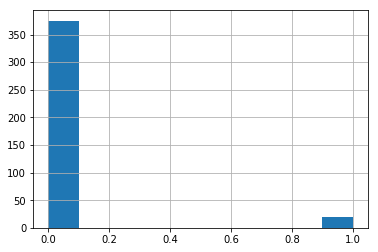

internet:


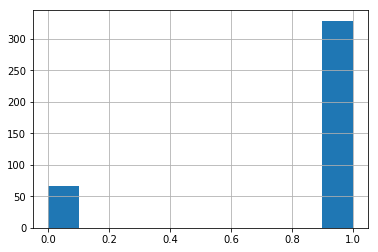

romantic:


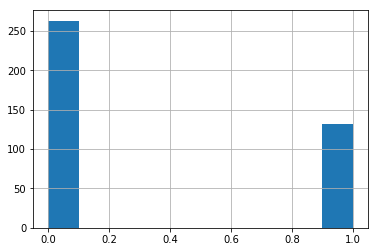

famrel:


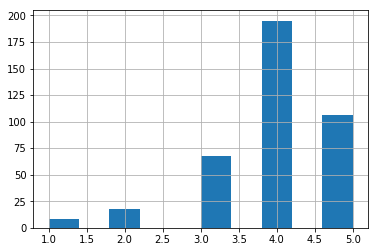

freetime:


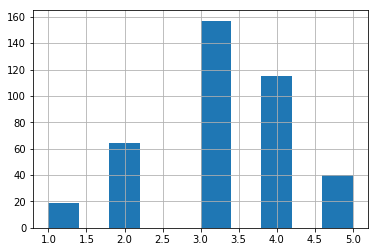

goout:


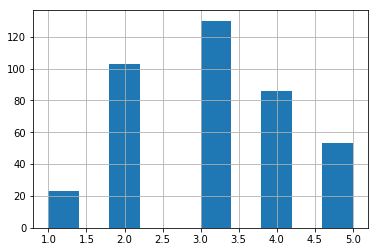

Dalc:


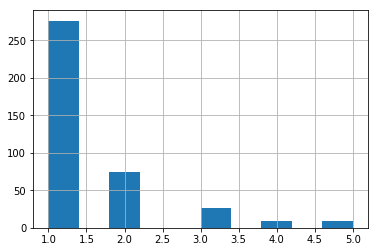

Walc:


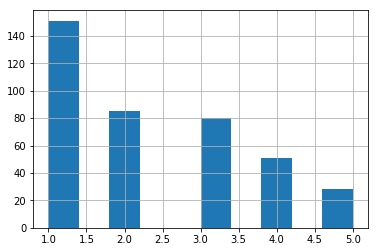

health:


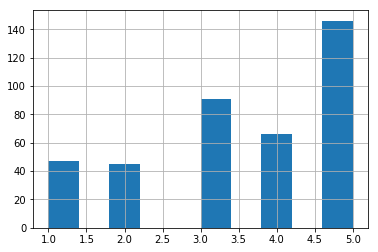

absences:


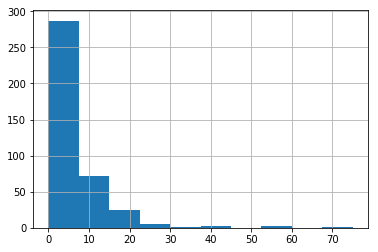

G1:


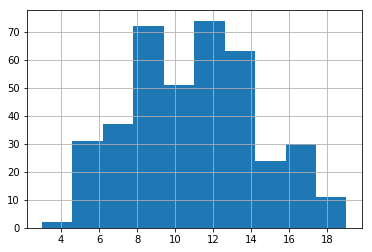

G2:


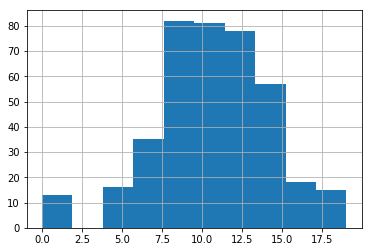

In [38]:
# Let's do some univariate analysis to understand the data better
def univariate(df):
    # numericals
    for col in df.select_dtypes(include=[np.number]).columns:
        print (col + ":")
        df[col].hist()
        plt.show()
    # non-numerical columns
    for col in df.select_dtypes(exclude=[np.number]).columns:
        if len(df[col].unique())<MIN_UNIQUE:
            print (col + ":")
            print (df[col].value_counts())
            print ()
univariate(df)

GP is 90% data, MS is 10% data approx Slightly more females than males 80% have urban address family size is large for 2/3rd of them

In [42]:
MIN_UNIQUE = 10
def bivariate(df, target):
    for col in df.columns:
        if (target!=col) & (len(df[col].unique())<MIN_UNIQUE):
            print (df.groupby(col)[target].mean())
            print ()
bivariate(df, "G1")

school
0    10.939828
1    10.673913
Name: G1, dtype: float64

sex
0    10.620192
1    11.229947
Name: G1, dtype: float64

age
15    11.231707
16    10.942308
17    10.897959
18    10.719512
19    10.250000
20    13.666667
21    10.000000
22     6.000000
Name: G1, dtype: float64

address
0    11.032573
1    10.477273
Name: G1, dtype: float64

famsize
0    10.758007
1    11.280702
Name: G1, dtype: float64

Pstatus
0    11.073171
1    10.889831
Name: G1, dtype: float64

Medu
0    12.000000
1     9.745763
2    10.563107
3    10.606061
4    11.908397
Name: G1, dtype: float64

Fedu
0    12.000000
1     9.731707
2    11.026087
3    10.740000
4    11.927083
Name: G1, dtype: float64

Mjob
0    10.457627
1    12.205882
2    10.177305
3    11.388350
4    11.534483
Name: G1, dtype: float64

Fjob
0    12.896552
1    10.566820
2    10.828829
3    11.444444
4    11.700000
Name: G1, dtype: float64

reason
0    10.600000
1    10.833333
2    10.816514
3    11.457143
Name: G1, dtype: float64

guardian
0

more than 3 failures has a strong effect on G1 grade wants to take higher education had a major effect on G1 all others had minimal effect

In [44]:
def correlations(df, target):
    print ("Pearson correlation:")
    print (abs(df.corr(method='pearson')[target]).sort_values(ascending=False))
    print ()
    print ("Spearman correlation:")
    print (abs(df.corr(method='spearman')[target]).sort_values(ascending=False))
    print ()
correlations(df, "G3")

Pearson correlation:
G3            1.000000
G2            0.904868
G1            0.801468
failures      0.360415
Medu          0.217147
higher        0.182465
age           0.161579
Fedu          0.152457
goout         0.132791
romantic      0.129970
traveltime    0.117142
address       0.105756
sex           0.103456
Mjob          0.102082
paid          0.101996
reason        0.099773
internet      0.098483
studytime     0.097820
schoolsup     0.082788
famsize       0.081407
health        0.061335
Pstatus       0.058009
Dalc          0.054660
guardian      0.054193
Walc          0.051939
nursery       0.051568
famrel        0.051363
school        0.045017
famsup        0.039157
absences      0.034247
Fjob          0.019246
activities    0.016100
freetime      0.011307
Name: G3, dtype: float64

Spearman correlation:
G3            1.000000
G2            0.957125
G1            0.878001
failures      0.361224
Medu          0.225036
age           0.173438
higher        0.172418
Fedu       

Final grade (G3) is highly correlated to second grade (G2) and first grade (G1) as expected and in that order

And now let's split the data into training, validation, and test sets. This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [45]:
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len(df)), int(0.9 * len(df))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

Now we'll upload these files to S3.

In [46]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

Training

In [47]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

Then, because we're training with the CSV file format, we'll create s3_inputs that our training function can use as a pointer to the files in S3.

In [48]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')
s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'output')

Create an instance of the sagemaker.estimator.Estimator class. 

In [49]:
xgb_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 5,
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())

xgb_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='local', #'ml.m4.xlarge',
                                         train_volume_size = 10,
                                         output_path=s3_output_location)
                                         #sagemaker_session=sagemaker.Session())

Set the hyperparameter values for xgboost

In [50]:
xgb_model.set_hyperparameters(max_depth = 5,
                              eta = .2,
                              gamma = 4,
                              min_child_weight = 6,
                              subsample=0.8,
                              silent = 0,
                              objective = 'reg:linear',
                              num_round = 100)

To start model training, call the estimator's fit method. 

In [51]:
xgb_model.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2019-07-22 22:10:36 Starting - Starting the training job...
2019-07-22 22:10:37 Starting - Launching requested ML instances......
2019-07-22 22:12:06 Starting - Preparing the instances for training......
2019-07-22 22:13:00 Downloading - Downloading input data
2019-07-22 22:13:00 Training - Downloading the training image..
Arguments: train
[2019-07-22:22:13:18:INFO] Running standalone xgboost training.
[2019-07-22:22:13:18:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 22308.4mb
[2019-07-22:22:13:18:INFO] Determined delimiter of CSV input is ','
[22:13:18] S3DistributionType set as FullyReplicated
[22:13:18] 276x32 matrix with 8832 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-07-22:22:13:18:INFO] Determined delimiter of CSV input is ','
[22:13:18] S3DistributionType set as FullyReplicated
[22:13:18] 79x32 matrix with 2528 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&


2019-07-22 22:13:30 Uploading - Uploading generated training model
2019-07-22 22:13:30 Completed - Training job completed
Billable seconds: 36


In [52]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                                instance_type='ml.m4.xlarge',
                                )

---------------------------------------------------------------------------------------------------!

In [56]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [57]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

dtest = test_data.as_matrix()
predictions = []
for i in range(dtest.shape[0]):
    predictions.append(predict(dtest[i:i+1, 1:]))
predictions = np.array(predictions).squeeze()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [58]:
test_data.head()

,G3,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
290,11,0,1,18,0,0,1,4,2,4,1,2,0,1,2,0,1,1,1,1,0,0,1,1,4,3,2,1,4,5,11,12,11
40,11,0,0,16,0,1,1,2,2,2,1,2,0,2,2,1,1,1,0,1,1,0,1,1,3,3,3,1,2,3,25,7,10
266,10,0,1,17,0,0,1,3,1,3,1,1,0,1,2,0,1,0,1,1,0,0,1,1,5,4,4,3,4,5,2,9,9
326,16,0,1,17,0,0,1,3,3,2,2,3,0,1,1,0,1,0,0,1,1,0,1,0,4,3,5,3,5,5,3,14,15
132,12,0,0,17,0,1,1,2,2,2,1,0,1,1,1,0,1,1,0,0,0,0,1,1,3,4,4,1,3,5,12,10,13


In [59]:
import numpy as np
from sklearn.metrics import mean_squared_error
print (np.sqrt(mean_squared_error(test_data['G3'], predictions)))

1.987468209605832


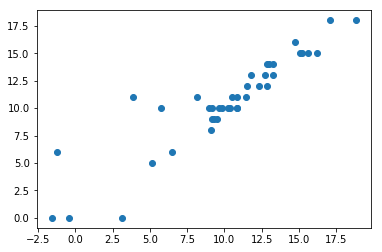

In [60]:
import matplotlib.pyplot as plt
plt.scatter(predictions, test_data['G3'])
plt.show()

Clean-up¶

If you're ready to be done with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)